In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
import time

In [2]:
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
df_book = pd.read_csv('data/children_book_processed_model.csv')

In [5]:
df_book.head()

,book_id,title,lem_word,publisher,average_rating,ratings_count,author_average_rating,author_ratings_count,rating
0,22007198,"""A"" IS FOR THE ALCHEMIST","['sister', 'brother', 'cat', 'dog', 'science',...",other_publisher,4.33,12,4.33,12,1
1,334,"""A"" Is for Zebra","['mark', 'shulman', 'tamara', 'petrosino', 're...",other_publisher,3.68,46,4.01,6540,0
2,25589071,"""A"" Things (A to Z Things #1)","['thing', 'learning', 'book', 'colorful', 'ill...",other_publisher,3.00,4,3.37,1289,0
3,2586488,"""A"" is for Salad","['salad', 'b', 'viking', 'welcome', 'wacky', '...",Puffin Books,4.04,11,3.98,1861,1
4,22600056,"""Am I a Chameleon?""","['chameleon', 'first', 'book', 'katiejane', 's...",other_publisher,4.57,7,4.16,31,1


In [6]:
X = df_book[['lem_word', 'publisher', 'author_average_rating']]

In [7]:
X.head()

,lem_word,publisher,author_average_rating
0,"['sister', 'brother', 'cat', 'dog', 'science',...",other_publisher,4.33
1,"['mark', 'shulman', 'tamara', 'petrosino', 're...",other_publisher,4.01
2,"['thing', 'learning', 'book', 'colorful', 'ill...",other_publisher,3.37
3,"['salad', 'b', 'viking', 'welcome', 'wacky', '...",Puffin Books,3.98
4,"['chameleon', 'first', 'book', 'katiejane', 's...",other_publisher,4.16


In [8]:
y = df_book['rating']

In [9]:
y

0        1
1        0
2        0
3        1
4        1
        ..
39959    1
39960    1
39961    0
39962    1
39963    1
Name: rating, Length: 39964, dtype: int64

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, 
                                                    random_state=42, stratify=y)

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, 
                                                  random_state=42, stratify=y_train)

In [12]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(22479, 3) (9991, 3) (22479,) (9991,)


Column transfers

In [13]:
# Create the column transformations list + columns to which to apply
col_transforms = [('ohe_transfer', OneHotEncoder(), ['publisher']),
                ('tfidf_transform', TfidfVectorizer(min_df=20, max_df=0.8), 'lem_word'),
                 ('scaler', MinMaxScaler(),['author_average_rating'])]

# Create the column transformer
col_trans = ColumnTransformer(col_transforms)

# Fit
transformers = col_trans.fit(X_train)

In [14]:
X_train_transformed = transformers.transform(X_train)
X_val_transformed = transformers.transform(X_val)
X_test_transformed = transformers.transform(X_test)

In [15]:
X_train_transformed = X_train_transformed.toarray()
X_test_transformed = X_test_transformed.toarray()
X_val_transformed = X_val_transformed.toarray()

### Build Neural Network

In [16]:
# Create a new sequential model
model1 = keras.Sequential()

# Create a regularizer with a factor of 0.005 and apply it to all hidden layers
regularizer = keras.regularizers.l2(0.01)

# Declare the hidden layers
model1.add(layers.Dense(64, activation="relu", kernel_regularizer=regularizer))
model1.add(layers.Dropout(0.3))
model1.add(layers.BatchNormalization()) 

# model1.add(layers.Dense(32, activation="relu", kernel_regularizer=regularizer))
# model1.add(layers.Dropout(0.3))
# model1.add(layers.BatchNormalization()) 

model1.add(layers.Dense(16, activation="relu", kernel_regularizer=regularizer)) 
model1.add(layers.Dropout(0.3))

# Declare the output layer
model1.add(layers.Dense(1, activation="sigmoid"))

model1.compile(
    
    optimizer=keras.optimizers.Adam(),  
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy()]
)


In [17]:
start = time.time()
# Train the network
NN_model1 = model1.fit(X_train_transformed, 
                      y_train, 
                      batch_size=5000,
                      epochs=200, 
                      verbose=0,
                     validation_data=(X_val_transformed, y_val))

stop = time.time()
runtime = stop-start
print(f"Runtime: {round(runtime,2)} seconds")

2023-01-11 21:23:29.944198: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Runtime: 83.96 seconds


In [19]:
# Evaluate the network
train_accuracy = NN_model1.history["binary_accuracy"][-1]
result = model1.evaluate(X_test_transformed,y_test,verbose=0)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[1]:.4f}")

Train Accuracy: 0.9824
Test Accuracy: 0.7071


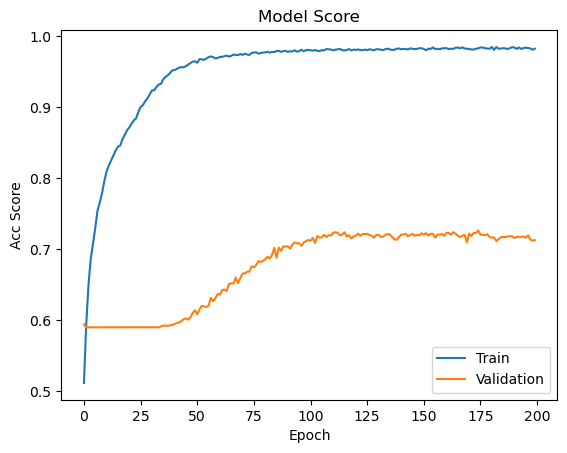

In [20]:
plt.plot(NN_model1.history['binary_accuracy'])
plt.plot(NN_model1.history['val_binary_accuracy'])
plt.title('Model Score')
plt.ylabel('Acc Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

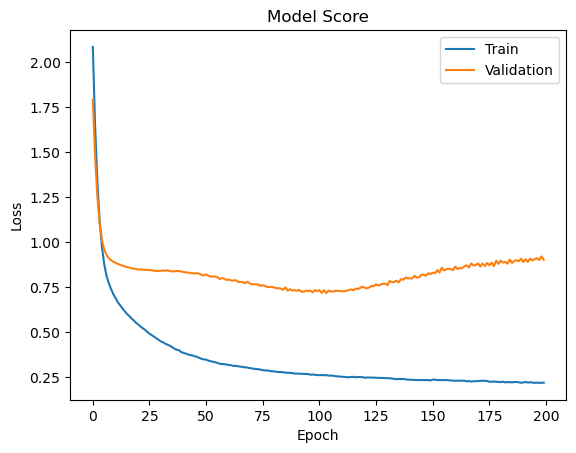

In [21]:
plt.plot(NN_model1.history['loss'])
plt.plot(NN_model1.history['val_loss'])
plt.title('Model Score')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [59]:
# Create a new sequential model
model4 = keras.Sequential()

# Create a regularizer with a factor of 0.005 and apply it to all hidden layers
regularizer = keras.regularizers.l2(0.05)

# Declare the hidden layers
model4.add(layers.Dense(64, activation="relu", kernel_regularizer=regularizer))
model4.add(layers.Dropout(0.5))
model4.add(layers.BatchNormalization()) 

# model1.add(layers.Dense(32, activation="relu", kernel_regularizer=regularizer))
# model1.add(layers.Dropout(0.3))
# model1.add(layers.BatchNormalization()) 

model4.add(layers.Dense(16, activation="relu", kernel_regularizer=regularizer)) 
model4.add(layers.Dropout(0.3))

# Declare the output layer
model4.add(layers.Dense(1, activation="sigmoid"))

model4.compile(
    
    optimizer=keras.optimizers.Adam(),  
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy()]
)

In [60]:
start = time.time()
# Train the network
NN_model4 = model4.fit(X_train_transformed, 
                      y_train, 
                      batch_size=5000,
                      epochs=150, 
                      verbose=0,
                     validation_data=(X_val_transformed, y_val))

stop = time.time()
runtime = stop-start
print(f"Runtime: {round(runtime,2)} seconds")

Runtime: 65.11 seconds


In [61]:
# Evaluate the network
train_accuracy = NN_model4.history["binary_accuracy"][-1]
result = model4.evaluate(X_test_transformed,y_test,verbose=0)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[1]:.4f}")

Train Accuracy: 0.8648
Test Accuracy: 0.7280


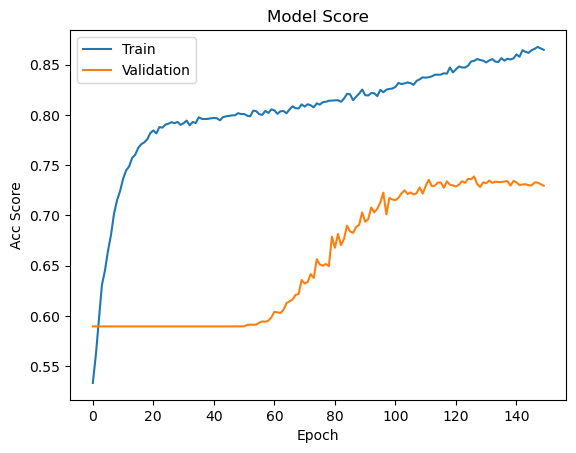

In [62]:
plt.plot(NN_model4.history['binary_accuracy'])
plt.plot(NN_model4.history['val_binary_accuracy'])
plt.title('Model Score')
plt.ylabel('Acc Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

### Improve overfitting

In [37]:
# Create a new sequential model
model2 = keras.Sequential()

# Create a regularizer with a factor of 0.005 and apply it to all hidden layers
regularizer = keras.regularizers.l1(0.005)

# Declare the hidden layers
model2.add(layers.Dense(64, activation="relu", kernel_regularizer=regularizer))
model2.add(layers.Dropout(0.2))
model2.add(layers.BatchNormalization()) 

# model2.add(layers.Dense(32, activation="relu", kernel_regularizer=regularizer))
# model2.add(layers.Dropout(0.3))
# model2.add(layers.BatchNormalization()) 

model2.add(layers.Dense(16, activation="relu", kernel_regularizer=regularizer)) 
model2.add(layers.Dropout(0.2))

# Declare the output layer
model2.add(layers.Dense(1, activation="sigmoid"))

model2.compile(
    
    optimizer=keras.optimizers.Adam(),  
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy()]
)

In [33]:
start = time.time()
# Train the network
NN_model2 = model2.fit(X_train_transformed, 
                      y_train, 
                      batch_size=5000,
                      epochs=150,
                      verbose=0,
                     validation_data=(X_val_transformed, y_val))
stop = time.time()
runtime = stop-start
print(f"Runtime: {round(runtime,2)} seconds")

Runtime: 66.93 seconds


In [34]:
# Evaluate the network
train_acc = NN_model2.history["binary_accuracy"][-1]
result = model2.evaluate(X_test_transformed, y_test, verbose=0)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {result[1]:.4f}")

Train Accuracy: 0.7368
Test Accuracy: 0.7344


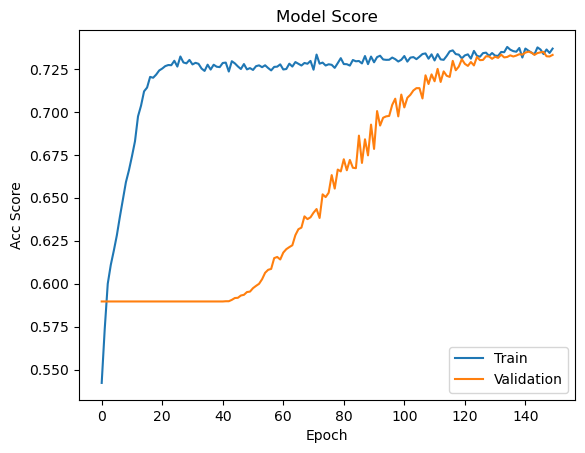

In [35]:
plt.plot(NN_model2.history['binary_accuracy'])
plt.plot(NN_model2.history['val_binary_accuracy'])
plt.title('Model Score')
plt.ylabel('Acc Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

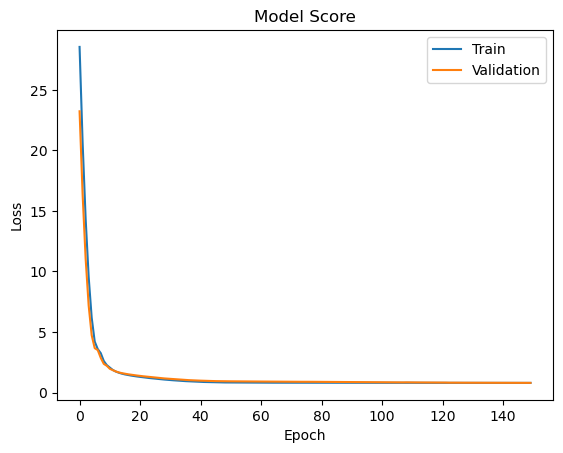

In [36]:
plt.plot(NN_model2.history['loss'])
plt.plot(NN_model2.history['val_loss'])
plt.title('Model Score')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [55]:
# Create a new sequential model
model3 = keras.Sequential()

# Create a regularizer with a factor of 0.005 and apply it to all hidden layers
regularizer = keras.regularizers.l1(0.005)

# Declare the hidden layers
model3.add(layers.Dense(128, activation="relu", kernel_regularizer=regularizer))
model3.add(layers.Dropout(0.2))
model3.add(layers.BatchNormalization()) 

# model3.add(layers.Dense(16, activation="relu", kernel_regularizer=regularizer))
# model3.add(layers.Dropout(0.2))
# model3.add(layers.BatchNormalization()) 

model3.add(layers.Dense(64, activation="relu", kernel_regularizer=regularizer)) 
model3.add(layers.Dropout(0.2))

# Declare the output layer
model3.add(layers.Dense(1, activation="sigmoid"))

model3.compile(
    
    optimizer=keras.optimizers.Adam(),  
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy()]
)

In [56]:
start = time.time()
# Train the network
NN_model3 = model3.fit(X_train_transformed, 
                      y_train, 
                      batch_size=5000,
                      epochs=150,
                      verbose=0,
                     validation_data=(X_val_transformed, y_val))
stop = time.time()
runtime = stop-start
print(f"Runtime: {round(runtime,2)} seconds")

Runtime: 81.07 seconds


In [57]:
# Evaluate the network
train_acc = NN_model3.history["binary_accuracy"][-1]
result = model3.evaluate(X_test_transformed, y_test, verbose=0)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {result[1]:.4f}")

Train Accuracy: 0.7334
Test Accuracy: 0.7327


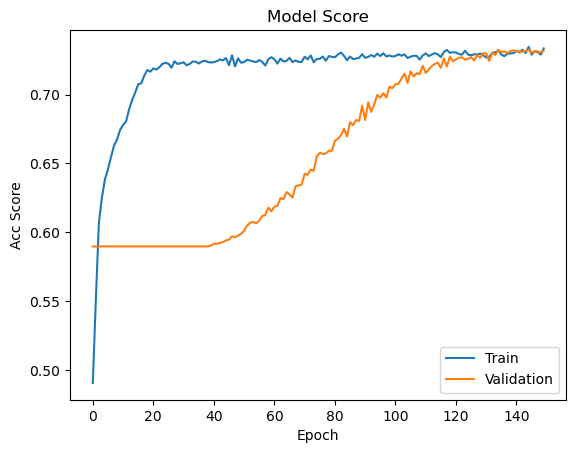

In [58]:
plt.plot(NN_model3.history['binary_accuracy'])
plt.plot(NN_model3.history['val_binary_accuracy'])
plt.title('Model Score')
plt.ylabel('Acc Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()